In [486]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


In [487]:
df = pd.read_csv('../CSV Files/df_ufc_masters_w_reversed.csv')

In [488]:
features = [
    'r_avg_sig_str_landed',
    'r_avg_sig_str_landed',
    'r_avg_sig_str_pct',
    'r_avg_sub_att',
    'r_avg_td_landed',
    'r_avg_td_pct',
    'r_height_cms',
    'r_reach_cms', 
    'r_age',
    'b_avg_sig_str_landed',
    'b_avg_sig_str_landed',
    'b_avg_sig_str_pct',
    'b_avg_sub_att',
    'b_avg_td_landed',
    'b_avg_td_pct',
    'b_height_cms',
    'b_reach_cms', 
    'b_age']


In [489]:
df['date'] = pd.to_datetime(df['date'])

In [490]:
type(df['date'])

pandas.core.series.Series

In [491]:
train_end_date = '2020-09-05'
test_start_date = '2020-09-06'

In [492]:
df_train = df[(df['date'] <= train_end_date)]
df_test = df[(df['date'] >= test_start_date)]

In [493]:
X_train =df_train[features]
y_train= df_train['winner']

In [494]:
X_test =df_test[features]
y_test= df_test['winner']

In [495]:
y_train_encoded = y_train.apply(lambda x: 1 if x == 'Red' else 0)
y_test_encoded = y_test.apply(lambda x: 1 if x == 'Red' else 0)

In [496]:
random_forest_model = RandomForestClassifier(n_estimators=50,max_depth=3,min_samples_split=5, random_state=42)
random_forest_model.fit(X_train, y_train_encoded)

RandomForestClassifier(max_depth=3, min_samples_split=5, n_estimators=50,
                       random_state=42)

In [497]:
y_pred_test = random_forest_model.predict(X_test)
y_pred_train = random_forest_model.predict(X_train)

In [498]:
y_pred_percent= random_forest_model.predict_proba(X_test)

In [499]:
y_pred_proba_df = pd.DataFrame(y_pred_percent, columns=['Probability_Blue', 'Probability_Red'])
result_df = pd.concat([df_test, y_pred_proba_df], axis=1)

In [500]:
#result_df=result_df[['R_fighter', 'B_fighter', 'Winner', 'R_odds', 'B_odds','R_ev', 'B_ev', 'Probability_Blue', 'Probability_Red']].copy().dropna()

In [501]:
condition_blue = (result_df['b_ev'] * result_df['Probability_Blue']-100*result_df['Probability_Red']) > 10
condition_red = (result_df['r_ev'] * result_df['Probability_Red'] - 100*result_df['Probability_Blue']) > 10

In [502]:
bank=0
for index, row in result_df.iterrows():
    if condition_blue[index]:
        bet_amount = 100  
        
        if row['winner'] == 'Blue':
            #bank +=1
            bank += row['b_ev'] * (bet_amount / 100)
        else:
            bank -= bet_amount
        #print(f"Who Win: {row['Winner']}, Blue price: {row['B_ev']}, Win prob: {row['Probability_Blue']}")

    elif condition_red[index]:
        bet_amount = 1  
        
        if row['winner'] == 'Red':
            #bank +=1
            bank += row['r_ev'] * (bet_amount / 100)
        else:
            bank -= bet_amount
        #print(f"Who Win: {row['Winner']}, Red price: {row['R_ev']}, Win prob: {row['Probability_Red']}")

print(bank)

-3719.8199999999997


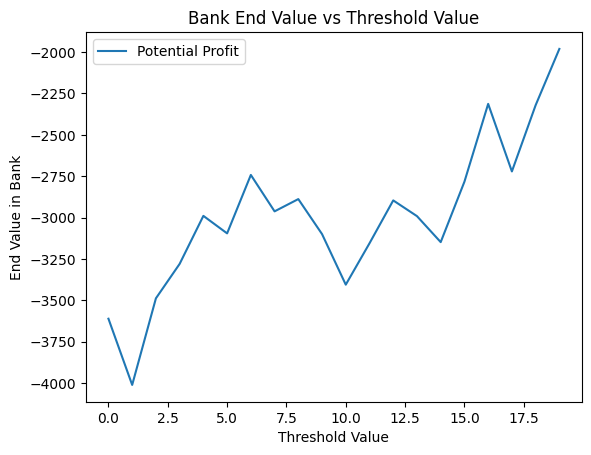

In [503]:
# Assuming result_df is your DataFrame
# Initialize bank to 0
bank = 0

# List of threshold values to test
threshold_values = range(0, 20)  # Adjust the range as needed

# Lists to store results
end_value = []

for threshold in threshold_values:
    condition_blue = (result_df['b_ev'] * result_df['Probability_Blue'] - 100 * result_df['Probability_Red']) > threshold
    condition_red = (result_df['r_ev'] * result_df['Probability_Red'] - 100 * result_df['Probability_Blue']) > threshold

    bank = 0  # Reset bank for each threshold value

    for index, row in result_df.iterrows():
        if condition_blue[index]:
            bet_amount = 100

            if row['winner'] == 'Blue':
                bank += row['b_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

        elif condition_red[index]:
            if row['winner'] == 'Red':
                bank += row['r_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

    end_value.append(bank if condition_blue.any() else 0)

    max_index = end_value.index(max(end_value))
    max_threshold = list(threshold_values)[max_index]
    max_value = max(end_value)

# Plotting the results
plt.plot(threshold_values, end_value, label='Potential Profit')
plt.xlabel('Threshold Value')
plt.ylabel('End Value in Bank')
plt.legend()
plt.title('Bank End Value vs Threshold Value')
plt.show()

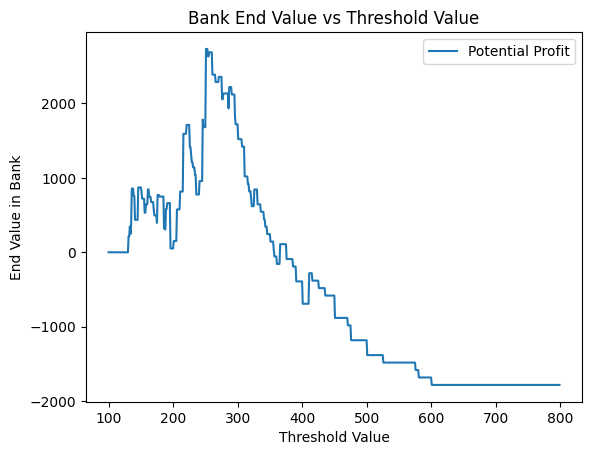

In [504]:
bank = 0
threshold_values = range(100, 800)
end_value = []

for threshold in threshold_values:
    condition_blue = ((result_df['b_ev'] * result_df['Probability_Blue'] - 100 * result_df['Probability_Red']) > max_index) & (result_df['b_ev']<threshold)
    condition_red = ((result_df['r_ev'] * result_df['Probability_Red'] - 100 * result_df['Probability_Blue']) > max_index) & (result_df['r_ev']<threshold)

    bank = 0 
    for index, row in result_df.iterrows():
        if condition_blue[index]:
            bet_amount = 100

            if row['winner'] == 'Blue':
                bank += row['b_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

        elif condition_red[index]:

            if row['winner'] == 'Red':
                bank += row['r_ev'] * (bet_amount / 100)
            else:
                bank -= bet_amount

    end_value.append(bank if condition_blue.any() else 0)

plt.plot(threshold_values, end_value, label='Potential Profit')
plt.xlabel('Threshold Value')
plt.ylabel('End Value in Bank')
plt.legend()
plt.title('Bank End Value vs Threshold Value')
plt.savefig("../DASH App/assets/bank_end_value_plot.png")

plt.show()

In [505]:
accuracy = accuracy_score(y_train_encoded, y_pred_train)
conf_matrix = confusion_matrix(y_train_encoded, y_pred_train)
classification_rep = classification_report(y_train_encoded, y_pred_train)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.6061
Confusion Matrix:
 [[2640 1722]
 [1714 2648]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61      4362
           1       0.61      0.61      0.61      4362

    accuracy                           0.61      8724
   macro avg       0.61      0.61      0.61      8724
weighted avg       0.61      0.61      0.61      8724



In [506]:
accuracy = accuracy_score(y_test_encoded, y_pred_test)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_test)
classification_rep = classification_report(y_test_encoded, y_pred_test)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.5768
Confusion Matrix:
 [[297 237]
 [215 319]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.56      0.57       534
           1       0.57      0.60      0.59       534

    accuracy                           0.58      1068
   macro avg       0.58      0.58      0.58      1068
weighted avg       0.58      0.58      0.58      1068



In [507]:
joblib.dump(random_forest_model, 'random_forest.pkl')

['random_forest.pkl']